# Ensemble Results for Normalized Detector

This notebook ensembles the results for the test database and calculates the average scores, and performance metrics from these scores. Note that the plotting functions are overkill; I created them for plotting the average scores across 10 models to plot the standard deviation for each model.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn
import time
from mlxtend.plotting import plot_confusion_matrix

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Functions

In [2]:
def compute_detections(labels, scores, threshold=0.5):

    scores = np.array(scores)
    labels = np.array(labels)

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [3]:
def load_models(model_names, temp_folders):
    models = []
    for idx, model_name in enumerate(model_names):
        models.append(ResNetInterface.load(model_file=model_name, new_model_folder=temp_folders[idx]))

    return models

In [4]:
def get_joint_batch_gen(db_name, table_name, batch_size):

    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, table_name)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

    return gen, db, table

In [5]:
def get_class_and_stats(gen, models, output_dir, db, table):

    all_scores_pos = pd.DataFrame()
    all_scores_neg = pd.DataFrame()

    for idx, model in enumerate(models):
    
        # Initialize the scores and labels
        scores = []
        labels = []
    
        # For each batch in the joint batch generator
        for batch_id in range(gen.n_batches):
            # Get the ids, spectrograms, and labels for the data in the batch
            hdf5_ids, batch_X, batch_Y = next(gen)
    
            # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
            batch_labels = np.argmax(batch_Y, axis=1)
    
            # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
            batch_scores = model.model.predict_on_batch(batch_X)
    
            # Add these scores for this batch to the overall list
            scores.extend(batch_scores)
            labels.extend(batch_labels)
    
        scores_series_neg = pd.Series((v[0] for v in scores))
        scores_series_pos = pd.Series((v[1] for v in scores))
        all_scores_neg = pd.concat([all_scores_neg, scores_series_neg.rename('neg model' + str(idx))], axis=1)
        all_scores_pos = pd.concat([all_scores_pos, scores_series_pos.rename('pos model' + str(idx))], axis=1)
    
    pos_scores_mean = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].mean(axis=1)
    pos_scores_90 = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].quantile(0.9, axis=1)
    pos_scores_10 = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].quantile(0.1, axis=1)
    pos_scores_50 = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].quantile(0.5, axis=1)
    
    quantiles = [pos_scores_10, pos_scores_mean, pos_scores_90, pos_scores_50]
    
    classification_csv = ["classifications-10.csv", "classifications-mean.csv", "classifications-90.csv", "classifications-50.csv"]
    metric_csv = ["metrics-10.csv", "metrics-mean.csv", "metrics-90.csv", "metrics-50.csv"]
    stats_csv = ["stats-10.csv", "stats-mean.csv", "stats-90.csv", "stats-50.csv"]
    
    thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    step_size = 1.0
    batch_size = 16
    buffer = 0.5
    
    # Get pathway to metrics folder
    temp_folder = output_dir + '\\' + 'temp'
    
    for idx, quant in enumerate(quantiles):
    
        df_groups = pd.DataFrame()
        df_stats = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
        for threshold in thresholds:
    
            df_group = pd.DataFrame()
    
            # Compute the predictions, TP, TN, FP, and FN
            # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
            predicted, TP, TN, FP, FN = compute_detections(labels, quant, threshold)
    
            # Create the "classifications" csv file
            for group in db.walk_nodes(table, "Table"):
                df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
                df_group = pd.concat([df_group, df], ignore_index=True)
            df_group['threshold'] = threshold
            df_group['label'] = labels[:]
            df_group['predicted'] = predicted[:]
            df_group['score'] = quant[:]
    
            # Calculate performance metrics
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * precision * recall / (precision + recall)
            FPP = FP / (TN + FP)
    
            stats = [threshold, precision, recall, f1, FPP]
    
            df_groups = pd.concat([df_groups, df_group])
            df_stats.loc[len(df_stats)] = stats

        stats_folder = output_dir +'\stats'
        if not os.path.exists(stats_folder):
            os.makedirs(stats_folder)

        class_folder = output_dir +'\class'
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
    
        df_groups.to_csv(os.path.join(os.getcwd(), output_dir + '\class', classification_csv[idx]), mode='w', index=False)
        df_stats.to_csv(os.path.join(os.getcwd(), output_dir +'\stats', stats_csv[idx]), mode='w', index=False)
    
    db.close()

In [6]:
def plot_stats(folder):
    
    files = glob.glob(folder + '\*.csv')
    
    precision = pd.DataFrame(columns=['threshold'])
    recall = pd.DataFrame(columns=['threshold'])
    f1 = pd.DataFrame(columns=['threshold'])
    
    for idx, file in enumerate(files):
    
        csv_f = pd.read_csv(file)
    
        if idx == 0:
            precision['threshold'] = csv_f['threshold']
            recall['threshold'] = csv_f['threshold']
            f1['threshold'] = csv_f['threshold']
    
        model_name = file.split("\\")[-1].split('.')[0]
        precision[model_name] = csv_f['precision'].tolist()
        recall[model_name] = csv_f['recall'].tolist()
        f1[model_name] = csv_f['f1'].tolist()
    
    plt.plot(precision['threshold'], precision['stats-mean'], '#377eb8', label='Precision')
    plt.fill_between(precision['threshold'], precision['stats-10'], precision['stats-90'], color='#377eb8', alpha=0.2)
    plt.plot(recall['threshold'], recall['stats-mean'], '#ff7f00', label='Recall')
    plt.fill_between(recall['threshold'], recall['stats-10'], recall['stats-90'], color='#ff7f00', alpha=0.2)
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.savefig(folder + '\\' + 'percentile_metrics-mean.png')
    plt.close()
    
    plt.plot(precision['threshold'], precision['stats-50'], '#377eb8', label='Precision')
    plt.fill_between(precision['threshold'], precision['stats-10'], precision['stats-90'], color='#377eb8', alpha=0.2)
    plt.plot(recall['threshold'], recall['stats-50'], '#ff7f00', label='Recall')
    plt.fill_between(recall['threshold'], recall['stats-10'], recall['stats-90'], color='#ff7f00', alpha=0.2)
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.savefig(folder + '\\' + 'percentile_metrics-median.png')

In [7]:
def plot_blue_confusion(folder, threshold_plot):

    files = glob.glob(folder + '\*.csv')
    
    thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
                  0.95, 1]

    all = []
    
    for idx, file in enumerate(files):
    
        class_file = pd.read_csv(file)
    
        for threshold in thresholds:
    
            temp = class_file[class_file['threshold'] == threshold]
    
            predicted, TP, TN, FP, FN = compute_detections(temp['label'], temp['score'], threshold)
    
            model_name = file.split("\\")[-1].split('.')[0]
            temp_array = [model_name, threshold, TP, TN, FP, FN]
    
            all.append(temp_array)
    
    df = pd.DataFrame(all, columns=["model", "threshold", "TP", "TN", "FP", "FN"])
    
    df_calcs_edited = df[df['threshold'] != 0]
    df_calcs_edited = df_calcs_edited[df_calcs_edited['threshold'] != 1]
    
    #df_mean = df_calcs_edited[df_calcs_edited['model']=='classifications-mean']
    df_med = df_calcs_edited[df_calcs_edited['model']=='classifications-50']
    df_90 = df_calcs_edited[df_calcs_edited['model']=='classifications-90']
    df_10 = df_calcs_edited[df_calcs_edited['model']=='classifications-10']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
    ax1.plot(df_med['threshold'], df_med['TP'], '#377eb8', label='TP')
    ax1.fill_between(df_med['threshold'], df_10['TP'], df_90['TP'], color='#377eb8', alpha=0.2)
    
    ax1.plot(df_med['threshold'], df_med['TN'], '#ff7f00', label='TN')
    ax1.fill_between(df_med['threshold'], df_10['TN'], df_90['TN'], color='#ff7f00', alpha=0.2)
    
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Number")
    ax1.legend()
    
    ax2.plot(df_med['threshold'], df_med['FP'], '#4daf4a', label='FP')
    ax2.fill_between(df_med['threshold'], df_10['FP'], df_90['FP'], color='#4daf4a', alpha=0.2)
    
    ax2.plot(df_med['threshold'], df_med['FN'], '#999999', label='FN')
    ax2.fill_between(df_med['threshold'], df_10['FN'], df_90['FN'], color='#999999', alpha=0.2)
    ax2.set_xlabel("Threshold")
    ax2.set_ylabel("Number")
    ax2.legend()
    
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    plt.tight_layout()
    plt.savefig(folder + '\\' + 'median_counts.png')
    
    ## Plot Confusion Matrix
    df_confs = df_med[df_med['threshold']==threshold_plot]
    
    # Your Confusion Matrix
    cm = np.array([[round(float(df_confs['TP']), 2), round(float(df_confs['FP']), 2)],
                   [round(float(df_confs['FN']), 2), round(float(df_confs['TN']), 2)]])
    
    # Classes
    classes = ['RS', 'O']
    
    figure2, ax = plot_confusion_matrix(conf_mat = cm,
                                       class_names = classes,
                                       show_absolute = True,
                                       show_normed = True,
                                       colorbar = True)
    
    plt.tight_layout()
    plt.savefig(folder + '\\' + 'confusion_matrix_median.png')

## Define Models

In [8]:
model_folder = r'E:\baseline-with-normalization-reduce-tonal\models'

model_names = [model_folder + "\\" + "rs-model-0.kt", model_folder + "\\" + "rs-model-1.kt", model_folder + "\\" + "rs-model-2.kt",
            model_folder + "\\" + "rs-model-3.kt", model_folder + "\\" + "rs-model-4.kt", model_folder + "\\" + "rs-model-5.kt",
            model_folder + "\\" + "rs-model-6.kt", model_folder + "\\" + "rs-model-7.kt", model_folder + "\\" + "rs-model-8.kt",
            model_folder + "\\" + "rs-model-9.kt"]

temp_folders = [model_folder + "\\" + "temp-0", model_folder + "\\" + "temp-1", model_folder + "\\" + "temp-2",
            model_folder + "\\" + "temp-3", model_folder + "\\" + "temp-4", model_folder + "\\" + "temp-5",
            model_folder + "\\" + "temp-6", model_folder + "\\" + "temp-7", model_folder + "\\" + "temp-8",
            model_folder + "\\" + "temp-9"]


spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

batch_size = 16

## Test Database

In [9]:
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'

temp_folder = model_folder + '\\' + 'temp-ensemble'

stats_folder = output_dir + '\stats'
class_folder = output_dir + '\class'

db_name = r'E:\baseline-with-normalization-reduce-tonal\final-baseline-db-normalized-rtn.h5'

table_name = '/test'

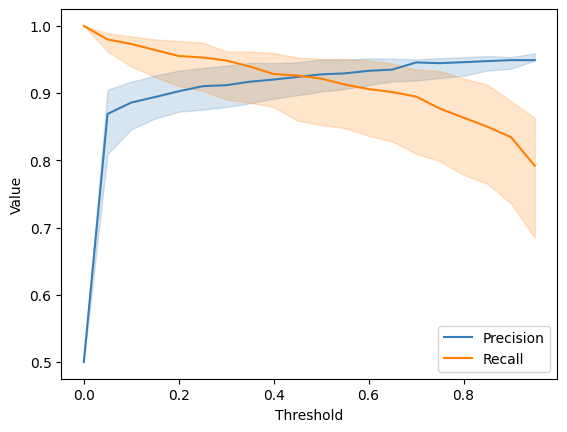

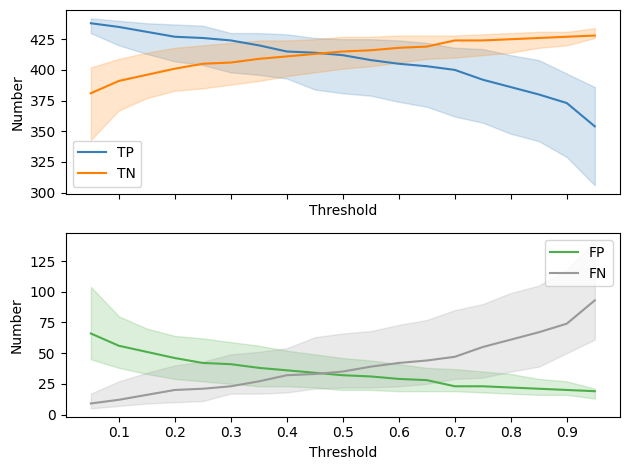

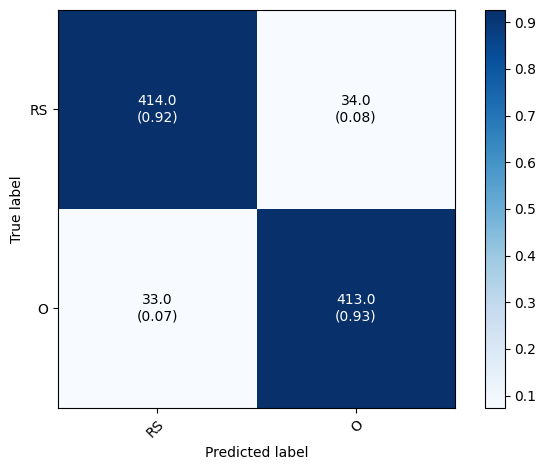

In [10]:
# load the models
models = load_models(model_names, temp_folders)

# get the batch generator, database, and table from database
gen, db, table = get_joint_batch_gen(db_name, table_name, batch_size)

# output classification and stats tables into the output directory in csv format
get_class_and_stats(gen, models, output_dir, db, table)

plot_stats(stats_folder)

plot_blue_confusion(class_folder, threshold_plot=0.45)

thresh: 0.45, prec: 
0.92410, recall: 
0.9261, f1: 4
0.92, FPP: 14
0.07063


## Ulu 2023

In [20]:
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'

stats_folder = output_dir + '\stats'
class_folder = output_dir + '\class'

temp_folder = model_folder + '\\' + 'temp-ensemble'

db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5'

table_name = '/all'

In [21]:
# load the models
models = load_models(model_names, temp_folders)

# get the batch generator, database, and table from database
gen, db, table = get_joint_batch_gen(db_name, table_name, batch_size)

# output classification and stats tables into the output directory in csv format
get_class_and_stats(gen, models, output_dir, db, table)

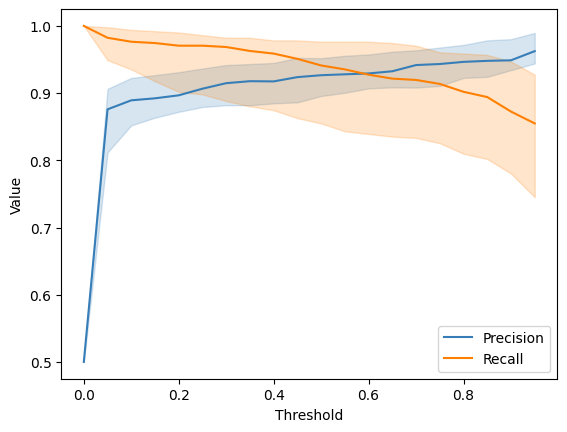

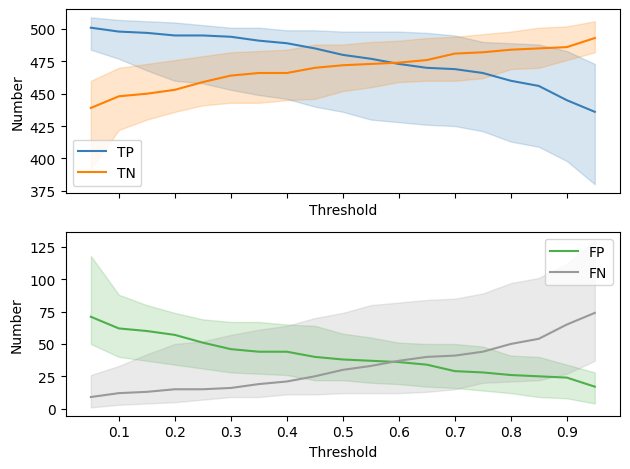

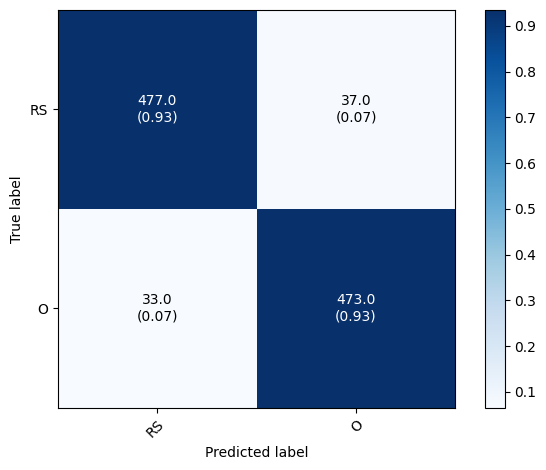

In [23]:
plot_stats(stats_folder)

plot_blue_confusion(class_folder, threshold_plot=0.55)

threshold: 0.55, prec: 0.928015564, recall:0.935294118, F1:0.931640625, FPP:0.07254902

## Pearce Point

In [24]:
output_dir = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'

stats_folder = output_dir + '\stats'
class_folder = output_dir + '\class'

temp_folder = model_folder + '\\' + 'temp-ensemble'

db_name = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\pp-all.h5'

table_name = '/all'

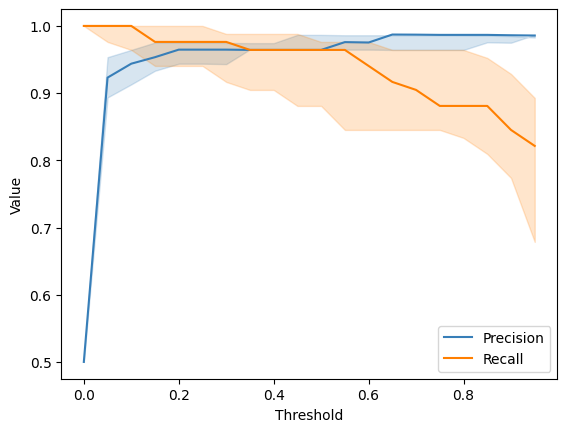

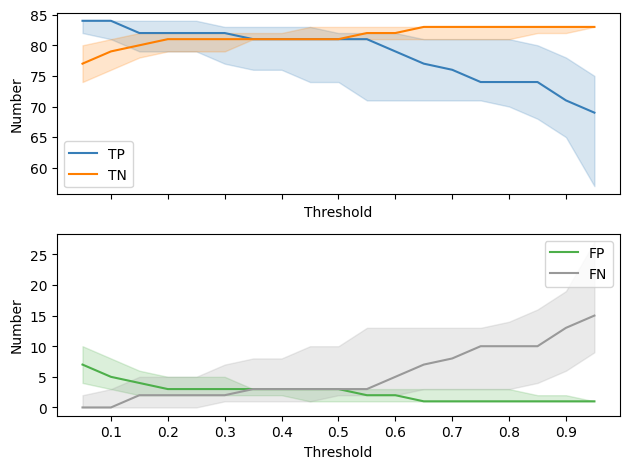

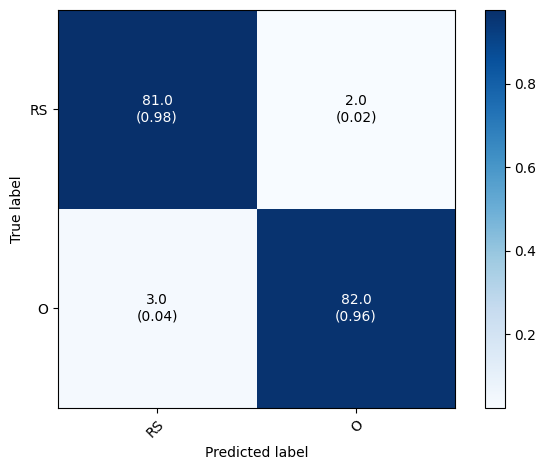

In [25]:
# load the models
models = load_models(model_names, temp_folders)

# get the batch generator, database, and table from database
gen, db, table = get_joint_batch_gen(db_name, table_name, batch_size)

# output classification and stats tables into the output directory in csv format
get_class_and_stats(gen, models, output_dir, db, table)

plot_stats(stats_folder)

plot_blue_confusion(class_folder, threshold_plot=0.55)

thresh:0.55, prec:0.975903614, recall:0.964285714, f1:0.97005988, FPP: 0.023809524
